# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import lusee
import sys, os
from scipy.interpolate import interp1d
sys.path.append('/home/anze/work/lusee/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='/home/anze/work/lusee/Drive/'
from algorithms import  Comb, Calibrator

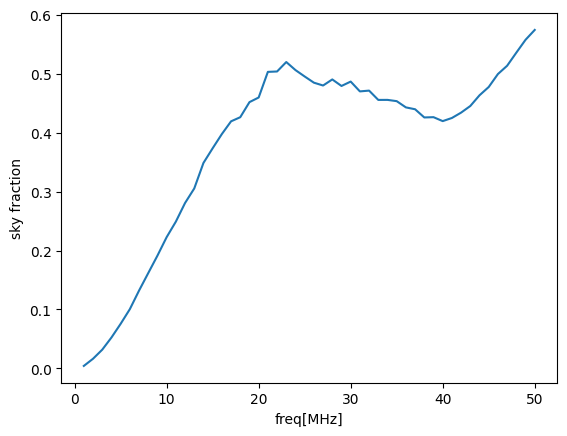

In [2]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




Text(0, 0.5, 'sky brightness [W/m^2/Hz/sr]')

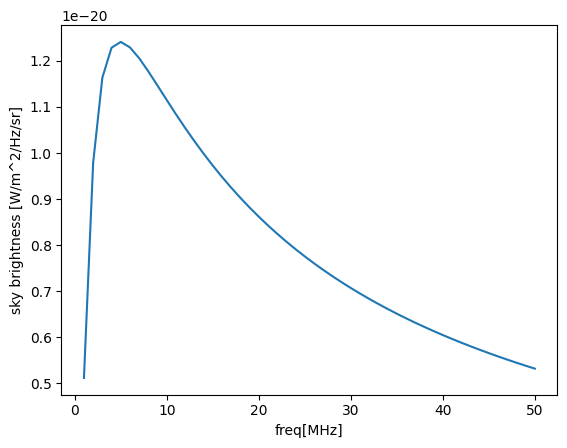

In [3]:
plt.plot(B.freq,lusee.MonoSkyModels.B_NB(B.freq))
plt.xlabel('freq[MHz]')
plt.ylabel('sky brightness [W/m^2/Hz/sr]')

Power per tone 1e-17 W/m^2


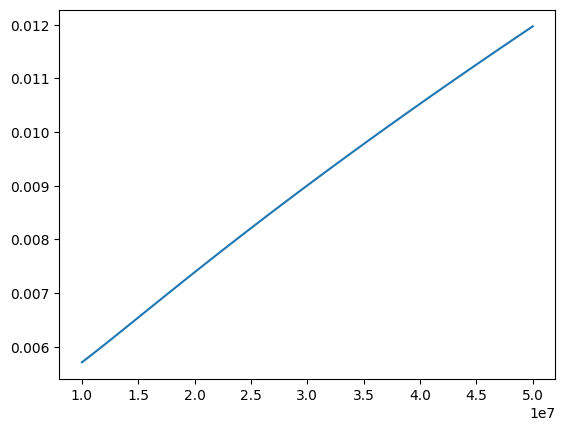

In [154]:
# define signal and sky signals
req_level = 1e-22 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

def signal(freq):
    freq_MHz = freq/1e6
    sf = sky_fraction(freq_MHz)
    return req_level*sf

def noise(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area
    return sky_signal

freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal(freq)/noise(freq))
#plt.plot(freq,noise(freq))

In [150]:
comb=Comb(Nstart= 181, Nend= 983, response=signal, noise=noise)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=512)
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=-0.4,tmax=50)
res['detect'], res['SNRdBdet']

(array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

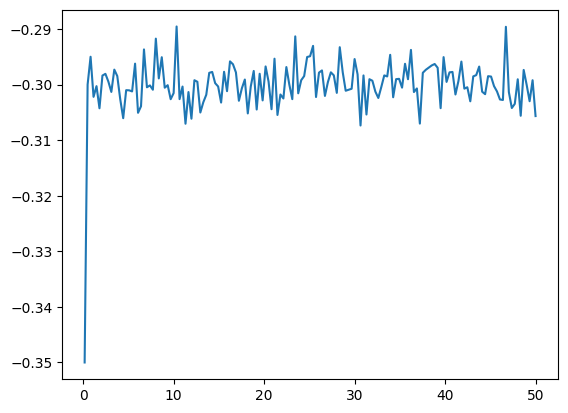

In [151]:
plt.plot(res['t'], res['alphadet'])

#plt.xlim(0,1)

In [152]:
comb=Comb(response=signal, noise=noise)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

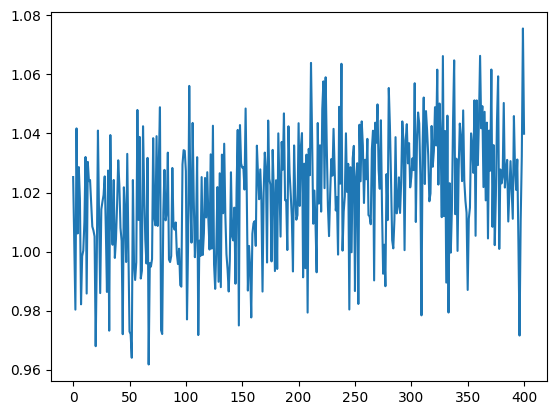

In [153]:
plt.plot(nb/wb)
